In [1]:
import sys
print(sys.version)
print(sys.base_prefix)

3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
C:\Users\1\anaconda3\envs\VKR_new


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Normalization
from keras.layers import Dropout

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# Импортируем данных
df_nup = pd.read_excel("dataset/X_nup.xlsx")
df_bp = pd.read_excel("dataset/X_bp.xlsx")

In [4]:
# Объединяем два датафрейма функцией merge по столбцу 'Unnamed: 0'. Используем метод Inner.
df_merge = df_bp.merge(df_nup, on = 'Unnamed: 0', how = 'inner')

In [5]:
# Удаляем столбец с нумерацией, который дублирует информацию
df = df_merge.drop(columns = ['Unnamed: 0'], axis = 1)

In [6]:
#Поменяем тип данных для Угла нашивки
df['Угол нашивки, град'] = df['Угол нашивки, град'].astype('float64')

In [7]:
#Переименуем колонки
df.rename(columns = {'Соотношение матрица-наполнитель':'matrix_filler', 
                     'Плотность, кг/м3':'density', 'модуль упругости, ГПа':'elastic_modulus',
                     'Количество отвердителя, м.%':'hardener', 'Содержание эпоксидных групп,%_2':'epoxies', 
                     'Температура вспышки, С_2':'temp', 'Поверхностная плотность, г/м2':'surface_density', 
                     'Модуль упругости при растяжении, ГПа':'tensile_modulus',
                     'Прочность при растяжении, МПа':'tensile_strength', 'Потребление смолы, г/м2':'resin_consumption', 
                     'Угол нашивки, град':'patch_angle', 'Шаг нашивки':'patch_step', 'Плотность нашивки':'patch_density'},
          inplace = True )

In [8]:
df.columns
for i in df.columns:
    perc25=np.quantile(df[i],0.25)
    perc75=np.quantile(df[i],0.75)
    IQR=perc75-perc25
    df.loc[((perc75+1.5*IQR<df[i])|(perc25-1.5*IQR>df[i])),i]=np.median(df[i])
describe = df.describe().T
describe['median'] = df.median()
describe

,count,mean,std,min,25%,50%,75%,max,median
matrix_filler,1023.0,2.925149,0.892296,0.547391,2.321061,2.906878,3.548775,5.314144,2.906878
density,1023.0,1974.780371,70.843060,1784.482245,1924.535020,1977.621657,2020.628746,2161.565216,1977.621657
elastic_modulus,1023.0,737.725703,326.453983,2.436909,500.047452,739.664328,957.386959,1649.415706,739.664328
hardener,1023.0,110.558141,26.661661,38.668500,92.883002,110.564840,129.233303,181.828448,110.564840
epoxies,1023.0,22.241659,2.369521,15.695894,20.615227,22.230744,23.961468,28.955094,22.230744
temp,1023.0,285.949096,39.355511,179.374391,259.372264,285.896812,312.586724,386.067992,285.896812
surface_density,1023.0,480.887409,278.400280,0.603740,266.816645,451.864365,691.775979,1291.340115,451.864365
tensile_modulus,1023.0,73.310802,3.042662,65.553336,71.287231,73.268805,75.322176,81.417126,73.268805
tensile_strength,1023.0,2465.702548,465.480040,1250.392802,2146.295983,2459.524526,2755.823091,3705.672523,2459.524526
resin_consumption,1023.0,218.089920,57.681967,63.685698,179.932410,219.198882,256.760915,359.052220,219.198882


In [9]:
# Целевая переменная 'Соотношение матрица-наполнитель'
X_matrix = df.copy()
y_matrix = X_matrix.pop('matrix_filler')
X_matrix.shape, y_matrix.shape

((1023, 12), (1023,))

In [10]:
minmax_scaler = MinMaxScaler()
X_matrix_norm = minmax_scaler.fit_transform(X_matrix)
X_matrix_norm = pd.DataFrame(data = X_matrix_norm , columns = ['density', 'elastic_modulus','hardener','epoxies',
                                                'temp','surface_density','tensile_modulus','tensile_strength',
                                                'resin_consumption','patch_angle', 'patch_step','patch_density']
                      )
X_matrix_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
density,1023.0,0.504658,0.187871,0.0,0.371411,0.512193,0.626245,1.0
elastic_modulus,1023.0,0.446447,0.198214,0.0,0.302135,0.447624,0.579819,1.0
hardener,1023.0,0.502163,0.186237,0.0,0.378699,0.502210,0.632613,1.0
epoxies,1023.0,0.493677,0.178708,0.0,0.371013,0.492854,0.623384,1.0
temp,1023.0,0.515617,0.190405,0.0,0.387036,0.515364,0.644492,1.0
surface_density,1023.0,0.372101,0.215691,0.0,0.206249,0.349615,0.535487,1.0
tensile_modulus,1023.0,0.489005,0.191799,0.0,0.361445,0.486357,0.615795,1.0
tensile_strength,1023.0,0.494978,0.189583,0.0,0.364888,0.492462,0.613140,1.0
resin_consumption,1023.0,0.522755,0.195289,0.0,0.393568,0.526509,0.653680,1.0
patch_angle,1023.0,0.491691,0.500175,0.0,0.000000,0.000000,1.000000,1.0


In [11]:
y_matrix = pd.DataFrame(data = y_matrix,columns = ['matrix_filler'])

In [12]:
minmax_scaler = MinMaxScaler()
y_matrix_norm = minmax_scaler.fit_transform(y_matrix)
y_matrix_norm = pd.DataFrame(data = y_matrix_norm, columns = ['matrix_filler'])
y_matrix_norm.head()

,matrix_filler
0,0.274768
1,0.274768
2,0.274768
3,0.274768
4,0.466552


In [13]:
# Разделим на тренировочную и тестовую выборку для задачи с целевой переменной Соотношение матрица-наполнитель
X_matrix_train, X_matrix_test, y_matrix_train, y_matrix_test = train_test_split(X_matrix_norm, y_matrix_norm, 
                                                                                test_size=0.3, random_state=42)
print('X_matrix_train:', X_matrix_train.shape, 'y_matrix_train:', y_matrix_train.shape)
print('X_matrix_test:', X_matrix_test.shape, 'y_matrix_test:', y_matrix_test.shape)

X_matrix_train: (716, 12) y_matrix_train: (716, 1)
X_matrix_test: (307, 12) y_matrix_test: (307, 1)


In [14]:
X_matrix.describe().T

,count,mean,std,min,25%,50%,75%,max
density,1023.0,1974.780371,70.843060,1784.482245,1924.535020,1977.621657,2020.628746,2161.565216
elastic_modulus,1023.0,737.725703,326.453983,2.436909,500.047452,739.664328,957.386959,1649.415706
hardener,1023.0,110.558141,26.661661,38.668500,92.883002,110.564840,129.233303,181.828448
epoxies,1023.0,22.241659,2.369521,15.695894,20.615227,22.230744,23.961468,28.955094
temp,1023.0,285.949096,39.355511,179.374391,259.372264,285.896812,312.586724,386.067992
surface_density,1023.0,480.887409,278.400280,0.603740,266.816645,451.864365,691.775979,1291.340115
tensile_modulus,1023.0,73.310802,3.042662,65.553336,71.287231,73.268805,75.322176,81.417126
tensile_strength,1023.0,2465.702548,465.480040,1250.392802,2146.295983,2459.524526,2755.823091,3705.672523
resin_consumption,1023.0,218.089920,57.681967,63.685698,179.932410,219.198882,256.760915,359.052220
patch_angle,1023.0,44.252199,45.015793,0.000000,0.000000,0.000000,90.000000,90.000000


МОДЕЛЬ ДЛЯ СООТНОШЕНИЯ МАТРИЦЫ-НАПОЛНИТЕЛЬ

По заданию для соотношения матрица-наполнитель необходимо построить нейросеть. Но базовая модель DummyRegressor, возвращающая среднее, для оценки качества модели, тоже понадобится.

In [15]:
# Базовая модель для выборки с целевой переменной 'Соотношение матрица-наполнитель'
model_DummyRegressor = DummyRegressor(strategy="mean")
model_DummyRegressor.fit(X_matrix_train, y_matrix_train)

preds_matrix_dum_train = model_DummyRegressor.predict(X_matrix_train)
preds_matrix_dum_test = model_DummyRegressor.predict(X_matrix_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_dum_train = mean_absolute_error(y_matrix_train, preds_matrix_dum_train)
MSE_matrix_dum_train = mean_squared_error (y_matrix_train, preds_matrix_dum_train)
r2_matrix_dum_train = r2_score(y_matrix_train, preds_matrix_dum_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_dum_train) 
print('MSE_train:', MSE_matrix_dum_train) 
print('r2_train', r2_matrix_dum_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_dum_test = mean_absolute_error(y_matrix_test, preds_matrix_dum_test)
MSE_matrix_dum_test = mean_squared_error (y_matrix_test, preds_matrix_dum_test)
r2_matrix_dum_test = r2_score(y_matrix_test, preds_matrix_dum_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_dum_test) 
print('MSE_train:', MSE_matrix_dum_test) 
print('r2_train', r2_matrix_dum_test)

Точность модели на тренировочных данных
MAE_train: 0.14704748907802656
MSE_train: 0.034263177308213814
r2_train 0.0

Точность модели на тестовых данных
MAE_train: 0.15598641245607797
MSE_train: 0.03674818672116871
r2_train -0.0007547848868225682


Построение линейной модели нейронной сети с помощью библиотеки TensorFlow

Нейронная сеть с двумя скрытыми слоями по 8 нейронов

In [16]:
def baseline_model1():
    model = keras.Sequential()
    model.add(Dense(8, input_dim=12 , activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    return model

In [17]:
model1 = baseline_model1()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 104       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [18]:
%%time
history = model1.fit(
    X_matrix_train,
    y_matrix_train,
    validation_split=0.3,
    verbose=1, epochs=100)

Epoch 1/100
16/16 [==============================] - 2s 55ms/step - loss: 0.1996 - val_loss: 0.0747
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0675 - val_loss: 0.0655
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0614 - val_loss: 0.0611
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0571 - val_loss: 0.0574
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0538 - val_loss: 0.0534
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0509 - val_loss: 0.0518
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0491 - val_loss: 0.0490
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0471 - val_loss: 0.0470
Epoch 9/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0456 - val_loss: 0.0464
Epoch 10/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0444 - val_loss: 0.0444

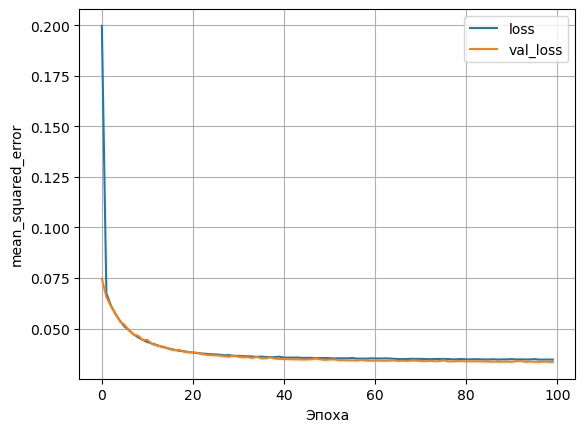

In [19]:
# График ошибки
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid(True)
plt.xlabel('Эпоха')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [20]:
# Проверяем точность сети на тестовых данных
train_rezult = model1.evaluate(X_matrix_train, y_matrix_train)
test_rezult = model1.evaluate(X_matrix_test, y_matrix_test)

10/10 [==============================] - 0s 4ms/step - loss: 0.0389


In [21]:
# Предсказание нейросети
preds_matrix_model1_train = model1.predict(X_matrix_train)
preds_matrix_model1_test = model1.predict(X_matrix_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model1_train = mean_absolute_error(y_matrix_train.values, preds_matrix_model1_train)
MSE_matrix_model1_train = mean_squared_error (y_matrix_train.values, preds_matrix_model1_train)
r2_matrix_model1_train = r2_score(y_matrix_train.values, preds_matrix_model1_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_model1_train) 
print('MSE_train:', MSE_matrix_model1_train) 
print('r2_train', r2_matrix_model1_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model1_test = mean_absolute_error(y_matrix_test.values, preds_matrix_model1_test)
MSE_matrix_model1_test = mean_squared_error (y_matrix_test.values, preds_matrix_model1_test)
r2_matrix_model1_test = r2_score(y_matrix_test.values, preds_matrix_model1_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_model1_test) 
print('MSE_train:', MSE_matrix_model1_test) 
print('r2_train', r2_matrix_model1_test)

10/10 [==============================] - 0s 5ms/step
Точность модели на тренировочных данных
MAE_train: 0.1476868025702365
MSE_train: 0.034205772743031666
r2_train 0.0016754011067267038

Точность модели на тестовых данных
MAE_train: 0.16063786656181314
MSE_train: 0.038852516958718795
r2_train -0.058061518690837755


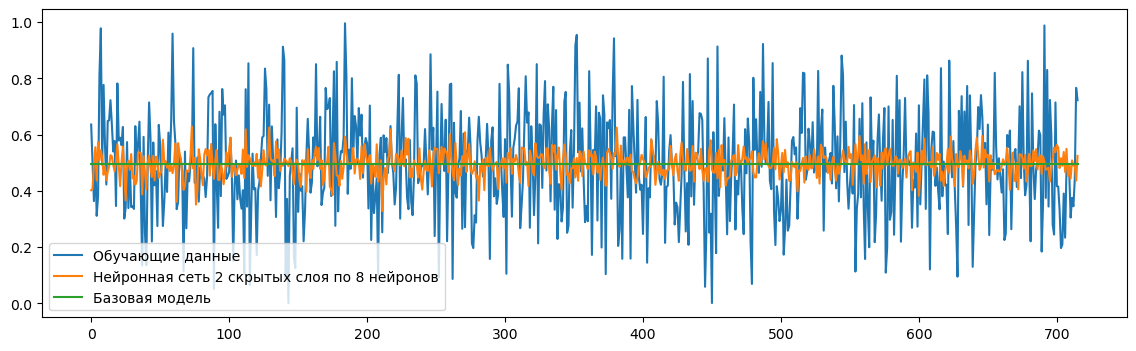

In [22]:
# Визуализация на обучающих данных данных
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_train.values, label='Обучающие данные')
ax.plot(preds_matrix_model1_train, label='Нейронная сеть 2 скрытых слоя по 8 нейронов')
ax.plot(preds_matrix_dum_train, label='Базовая модель')
ax.legend()
plt.show()

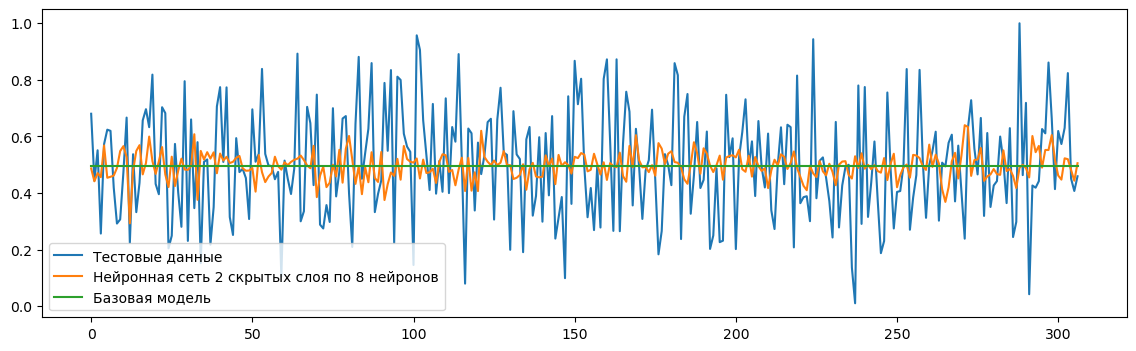

In [23]:
# Визуализация на тестовых данных
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_test.values, label='Тестовые данные')
ax.plot(preds_matrix_model1_test, label='Нейронная сеть 2 скрытых слоя по 8 нейронов')
ax.plot(preds_matrix_dum_test, label='Базовая модель')
ax.legend()
plt.show()

Попробуем в этой моделе поменять оптимизатор на adam

In [24]:
def baseline_model1_1():
    model = keras.Sequential()
    model.add(Dense(8, input_dim=12 , activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model1_1 = baseline_model1_1()

In [25]:
%%time
history = model1_1.fit(
    X_matrix_train,
    y_matrix_train,
    validation_split=0.3,
    verbose=1, epochs=50)

Epoch 1/50
16/16 [==============================] - 2s 35ms/step - loss: 0.1440 - val_loss: 0.0624
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0800 - val_loss: 0.0577
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0699 - val_loss: 0.0488
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0615 - val_loss: 0.0451
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0559 - val_loss: 0.0424
Epoch 6/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0522 - val_loss: 0.0402
Epoch 7/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0492 - val_loss: 0.0386
Epoch 8/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0464 - val_loss: 0.0373
Epoch 9/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0445 - val_loss: 0.0363
Epoch 10/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0429 - val_loss: 0.0355
Epoch 11/50


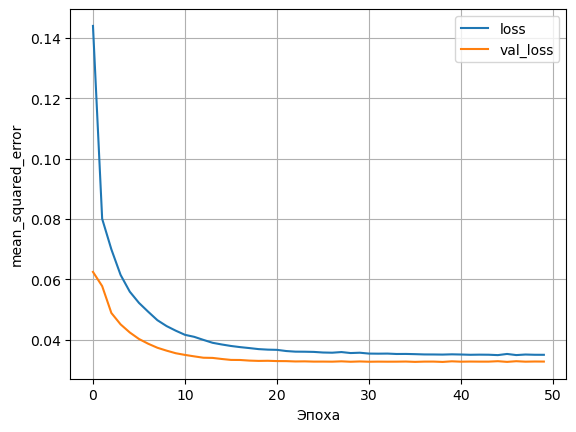

In [26]:
# График ошибки
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid(True)
plt.xlabel('Эпоха')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [27]:
# Проверяем точность сети на тестовых данных
train_rezult = model1_1.evaluate(X_matrix_train, y_matrix_train)
test_rezult = model1_1.evaluate(X_matrix_test, y_matrix_test)

10/10 [==============================] - 0s 4ms/step - loss: 0.0362


In [28]:
# Предсказание нейросети
preds_matrix_model1_1_train = model1_1.predict(X_matrix_train)
preds_matrix_model1_1_test = model1_1.predict(X_matrix_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model1_1_train = mean_absolute_error(y_matrix_train.values, preds_matrix_model1_1_train)
MSE_matrix_model1_1_train = mean_squared_error (y_matrix_train.values, preds_matrix_model1_1_train)
r2_matrix_model1_1_train = r2_score(y_matrix_train.values, preds_matrix_model1_1_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_model1_1_train) 
print('MSE_train:', MSE_matrix_model1_1_train) 
print('r2_train', r2_matrix_model1_1_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model1_1_test = mean_absolute_error(y_matrix_test.values, preds_matrix_model1_1_test)
MSE_matrix_model1_1_test = mean_squared_error (y_matrix_test.values, preds_matrix_model1_1_test)
r2_matrix_model1_1_test = r2_score(y_matrix_test.values, preds_matrix_model1_1_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_model1_1_test) 
print('MSE_train:', MSE_matrix_model1_1_test) 
print('r2_train', r2_matrix_model1_1_test)

10/10 [==============================] - 0s 3ms/step
Точность модели на тренировочных данных
MAE_train: 0.14814350631045822
MSE_train: 0.03416222172490073
r2_train 0.0029464746484233473

Точность модели на тестовых данных
MAE_train: 0.15548606248809332
MSE_train: 0.036206653904659214
r2_train 0.013992651807324119


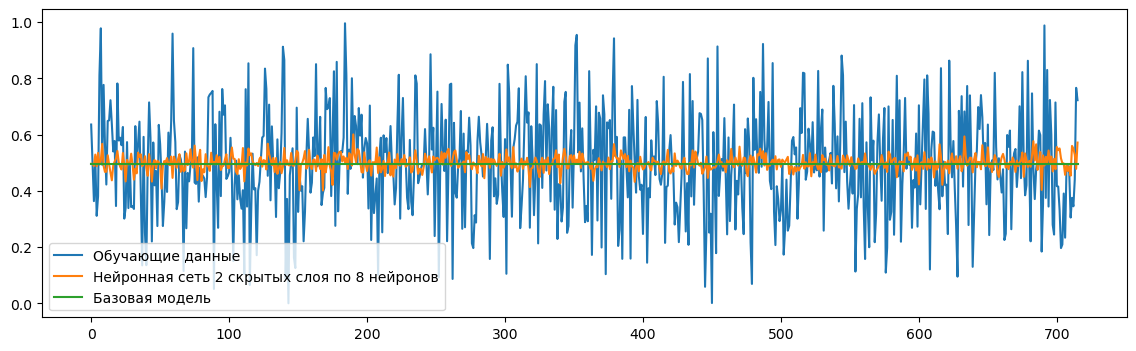

In [29]:
# Визуализация на обучающих данных данных
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_train.values, label='Обучающие данные')
ax.plot(preds_matrix_model1_1_train, label='Нейронная сеть 2 скрытых слоя по 8 нейронов')
ax.plot(preds_matrix_dum_train, label='Базовая модель')
ax.legend()
plt.show()

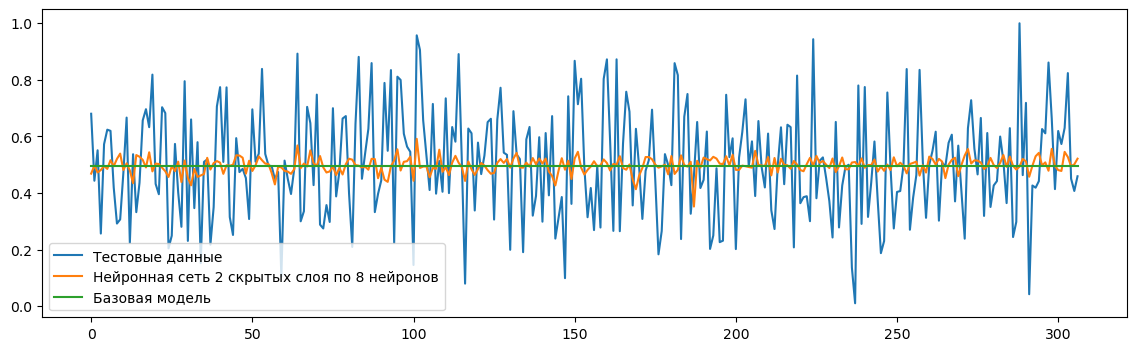

In [30]:
# Визуализация на тестовых данных
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_test.values, label='Тестовые данные')
ax.plot(preds_matrix_model1_1_test, label='Нейронная сеть 2 скрытых слоя по 8 нейронов')
ax.plot(preds_matrix_dum_test, label='Базовая модель')
ax.legend()
plt.show()

Метрики улучшились

Нейронная сеть с 6 скрытыми слоями по 8 нейронов

In [31]:
def baseline_model2():
    model = keras.Sequential()
    model.add(Dense(8, input_dim=12 , activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [32]:
model2 = baseline_model2()
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 104       
                                                                 
 dense_7 (Dense)             (None, 8)                 72        
                                                                 
 dense_8 (Dense)             (None, 8)                 72        
                                                                 
 dense_9 (Dense)             (None, 8)                 72        
                                                                 
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dense_11 (Dense)            (None, 8)                 72        
                                                                 
 dense_12 (Dense)            (None, 1)                

In [33]:
%%time
history = model2.fit(
    X_matrix_train,
    y_matrix_train,
    validation_split=0.3,
    verbose=1, epochs=50)

Epoch 1/50
16/16 [==============================] - 3s 42ms/step - loss: 0.2316 - val_loss: 0.0989
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0585 - val_loss: 0.0324
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0390 - val_loss: 0.0354
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0361 - val_loss: 0.0322
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0362 - val_loss: 0.0323
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0356 - val_loss: 0.0324
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0355 - val_loss: 0.0325
Epoch 8/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0354 - val_loss: 0.0325
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0355 - val_loss: 0.0326
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0353 - val_loss: 0.0327
Epoch 11/

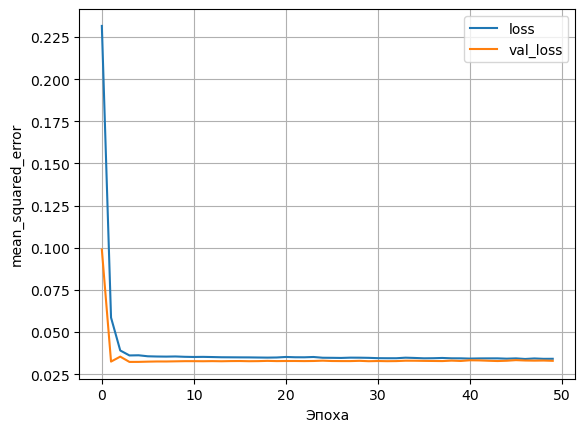

In [34]:
# График ошибки
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid(True)
plt.xlabel('Эпоха')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [35]:
# Проверяем точность сети на тестовых данных
train_rezult = model2.evaluate(X_matrix_train, y_matrix_train)
test_rezult = model2.evaluate(X_matrix_test, y_matrix_test)

10/10 [==============================] - 0s 4ms/step - loss: 0.0373


In [36]:
# Предсказание нейросети
preds_matrix_model2_train = model2.predict(X_matrix_train)
preds_matrix_model2_test = model2.predict(X_matrix_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model2_train = mean_absolute_error(y_matrix_train, preds_matrix_model2_train)
MSE_matrix_model2_train = mean_squared_error (y_matrix_train, preds_matrix_model2_train)
r2_matrix_model2_train = r2_score(y_matrix_train, preds_matrix_model2_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_model2_train) 
print('MSE_train:', MSE_matrix_model2_train) 
print('r2_train', r2_matrix_model2_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model2_test = mean_absolute_error(y_matrix_test, preds_matrix_model2_test)
MSE_matrix_model2_test = mean_squared_error (y_matrix_test, preds_matrix_model2_test)
r2_matrix_model2_test = r2_score(y_matrix_test, preds_matrix_model2_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_model2_test) 
print('MSE_train:', MSE_matrix_model2_test) 
print('r2_train', r2_matrix_model2_test)

10/10 [==============================] - 0s 4ms/step
Точность модели на тренировочных данных
MAE_train: 0.14608291562305295
MSE_train: 0.033686786970823855
r2_train 0.01682244271175004

Точность модели на тестовых данных
MAE_train: 0.15769823517126663
MSE_train: 0.03730163094099024
r2_train -0.015826602044954452


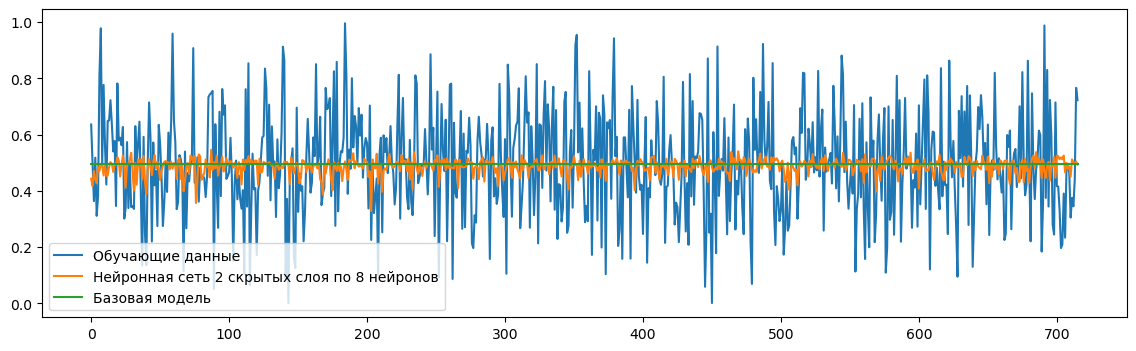

In [37]:
# Визуализация на обучающих данных данных
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_train.values, label='Обучающие данные')
ax.plot(preds_matrix_model2_train, label='Нейронная сеть 2 скрытых слоя по 8 нейронов')
ax.plot(preds_matrix_dum_train, label='Базовая модель')
ax.legend()
plt.show()

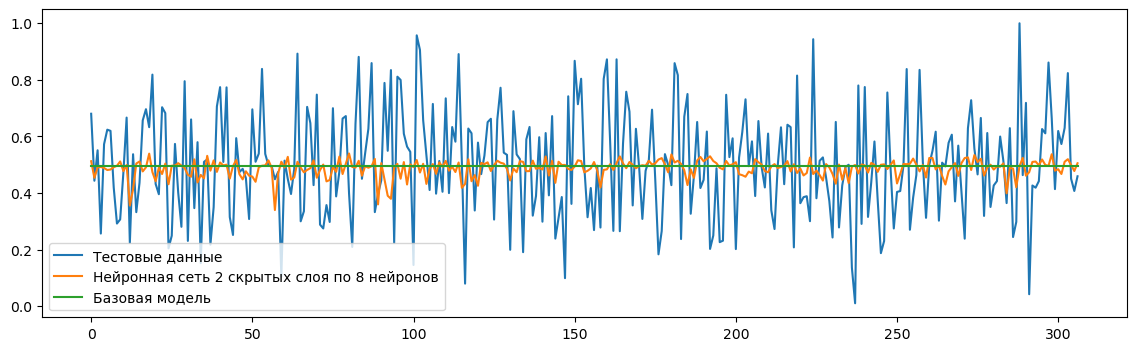

In [38]:
# Визуализация на тестовых данных
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_test.values, label='Тестовые данные')
ax.plot(preds_matrix_model2_test, label='Нейронная сеть 2 скрытых слоя по 8 нейронов')
ax.plot(preds_matrix_dum_test, label='Базовая модель')
ax.legend()
plt.show()

Попробуем добавить в модель с слои Dropout, чтобы модель не переучивалась. Хотя по функции потерь она и так не переучивалась, но попробуем в качестве эксперимента

In [39]:
def baseline_model3():
    model = keras.Sequential()
    model.add(Dense(8, input_dim=12 , activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(8, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(8, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(8, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(8, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [40]:
model3 = baseline_model3()
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 8)                 104       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_14 (Dense)            (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_15 (Dense)            (None, 8)                 72        
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 8)                

In [41]:
%%time
history = model3.fit(
    X_matrix_train,
    y_matrix_train,
    validation_split=0.3,
    verbose=1, epochs=100)

Epoch 1/100
16/16 [==============================] - 3s 44ms/step - loss: 0.2651 - val_loss: 0.1354
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.1039 - val_loss: 0.0476
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0477 - val_loss: 0.0345
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0467 - val_loss: 0.0351
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0445 - val_loss: 0.0330
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0434 - val_loss: 0.0327
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0416 - val_loss: 0.0331
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0404 - val_loss: 0.0329
Epoch 9/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0430 - val_loss: 0.0326
Epoch 10/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0397 - val_loss: 0.0328

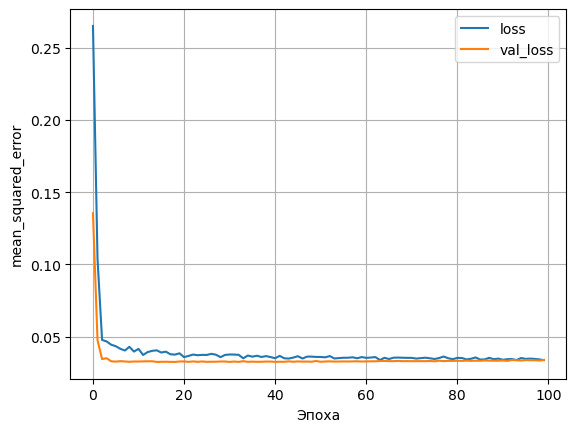

In [42]:
# График ошибки
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid(True)
plt.xlabel('Эпоха')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [43]:
# Проверяем точность сети на данных
train_rezult = model3.evaluate(X_matrix_train, y_matrix_train)
test_rezult = model3.evaluate(X_matrix_test, y_matrix_test)

10/10 [==============================] - 0s 4ms/step - loss: 0.0375


In [44]:
# Предсказание нейросети
preds_matrix_model3_train = model3.predict(X_matrix_train)
preds_matrix_model3_test = model3.predict(X_matrix_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model3_train = mean_absolute_error(y_matrix_train, preds_matrix_model3_train)
MSE_matrix_model3_train = mean_squared_error (y_matrix_train, preds_matrix_model3_train)
r2_matrix_model3_train = r2_score(y_matrix_train, preds_matrix_model3_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_model3_train) 
print('MSE_train:', MSE_matrix_model3_train) 
print('r2_train', r2_matrix_model3_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model3_test = mean_absolute_error(y_matrix_test, preds_matrix_model3_test)
MSE_matrix_model3_test = mean_squared_error (y_matrix_test, preds_matrix_model3_test)
r2_matrix_model3_test = r2_score(y_matrix_test, preds_matrix_model3_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_model3_test) 
print('MSE_train:', MSE_matrix_model3_test) 
print('r2_train', r2_matrix_model3_test)

10/10 [==============================] - 0s 4ms/step
Точность модели на тренировочных данных
MAE_train: 0.1468872060932608
MSE_train: 0.033818256641590085
r2_train 0.012985388442567913

Точность модели на тестовых данных
MAE_train: 0.1589596579535034
MSE_train: 0.037509799247975435
r2_train -0.021495600922583957


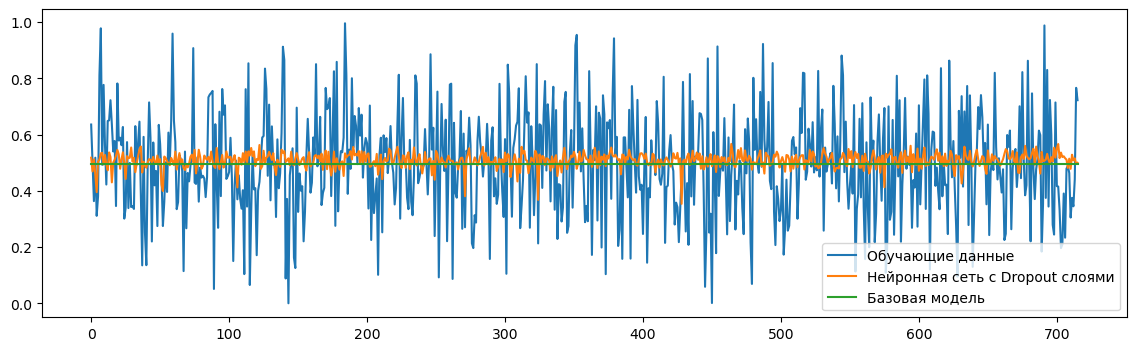

In [45]:
# Визуализация на обучающих данных 
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_train.values, label='Обучающие данные')
ax.plot(preds_matrix_model3_train, label='Нейронная сеть с Dropout слоями')
ax.plot(preds_matrix_dum_train, label='Базовая модель')
ax.legend()
plt.show()

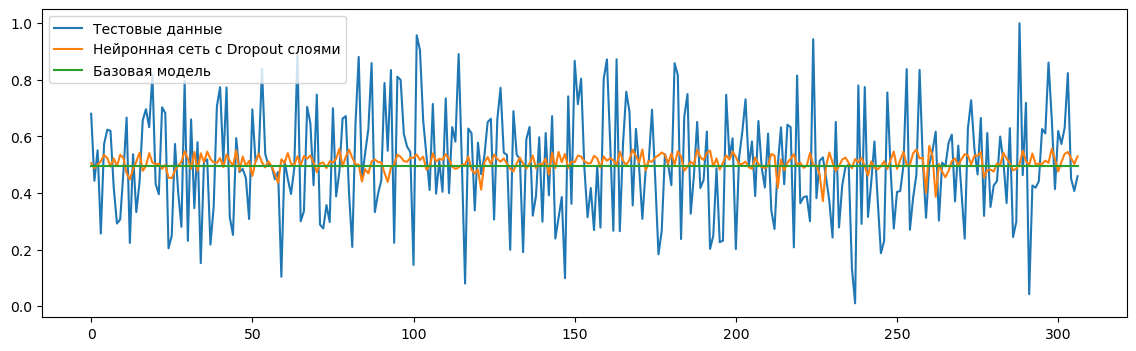

In [46]:
# Визуализация на тестовых данных данных 
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_test.values, label='Тестовые данные')
ax.plot(preds_matrix_model3_test, label='Нейронная сеть с Dropout слоями')
ax.plot(preds_matrix_dum_test, label='Базовая модель')
ax.legend()
plt.show()

Нейронная сеть со слоями дропаут дала результат лучше, чем без них. r2 на обучающих данных получилась положительной

Попробую увеличить количество нейронов в слоях

In [47]:
def baseline_model4():
    model = keras.Sequential()
    model.add(Dense(24, input_dim=12 , activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [48]:
model4 = baseline_model4()
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 24)                312       
                                                                 
 dropout_5 (Dropout)         (None, 24)                0         
                                                                 
 dense_21 (Dense)            (None, 24)                600       
                                                                 
 dropout_6 (Dropout)         (None, 24)                0         
                                                                 
 dense_22 (Dense)            (None, 24)                600       
                                                                 
 dropout_7 (Dropout)         (None, 24)                0         
                                                                 
 dense_23 (Dense)            (None, 24)               

In [49]:
%%time
history = model4.fit(
    X_matrix_train,
    y_matrix_train,
    validation_split=0.3,
    verbose=1, epochs=50)

Epoch 1/50
16/16 [==============================] - 3s 51ms/step - loss: 0.1756 - val_loss: 0.0516
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0551 - val_loss: 0.0340
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0508 - val_loss: 0.0332
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0474 - val_loss: 0.0346
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0452 - val_loss: 0.0330
Epoch 6/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0463 - val_loss: 0.0365
Epoch 7/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0454 - val_loss: 0.0327
Epoch 8/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0412 - val_loss: 0.0326
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0423 - val_loss: 0.0354
Epoch 10/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0408 - val_loss: 0.0328
Epoch 11/

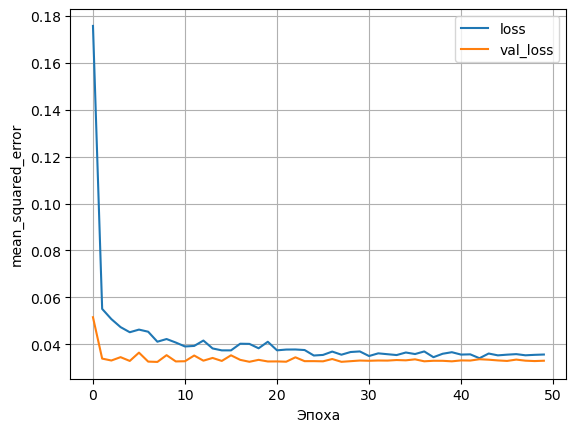

In [50]:
# График ошибки
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid(True)
plt.xlabel('Эпоха')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [51]:
# Проверяем точность сети на данных
train_rezult = model4.evaluate(X_matrix_train, y_matrix_train)
test_rezult = model4.evaluate(X_matrix_test, y_matrix_test)

10/10 [==============================] - 0s 4ms/step - loss: 0.0374


In [52]:
# Предсказание нейросети
preds_matrix_model4_train = model4.predict(X_matrix_train)
preds_matrix_model4_test = model4.predict(X_matrix_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model4_train = mean_absolute_error(y_matrix_train, preds_matrix_model4_train)
MSE_matrix_model4_train = mean_squared_error (y_matrix_train, preds_matrix_model4_train)
r2_matrix_model4_train = r2_score(y_matrix_train, preds_matrix_model4_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_model4_train) 
print('MSE_train:', MSE_matrix_model4_train) 
print('r2_train', r2_matrix_model4_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model4_test = mean_absolute_error(y_matrix_test, preds_matrix_model4_test)
MSE_matrix_model4_test = mean_squared_error (y_matrix_test, preds_matrix_model4_test)
r2_matrix_model4_test = r2_score(y_matrix_test, preds_matrix_model4_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_model4_test) 
print('MSE_train:', MSE_matrix_model4_test) 
print('r2_train', r2_matrix_model4_test)

10/10 [==============================] - 0s 4ms/step
Точность модели на тренировочных данных
MAE_train: 0.14625477554047578
MSE_train: 0.0336928349710122
r2_train 0.016645926677234746

Точность модели на тестовых данных
MAE_train: 0.1579961958917684
MSE_train: 0.037436783137751915
r2_train -0.019507170248862504


In [53]:
preds_matrix_model4_test = pd.DataFrame(preds_matrix_model4_test)
preds_matrix_model4_test.shape

(307, 1)

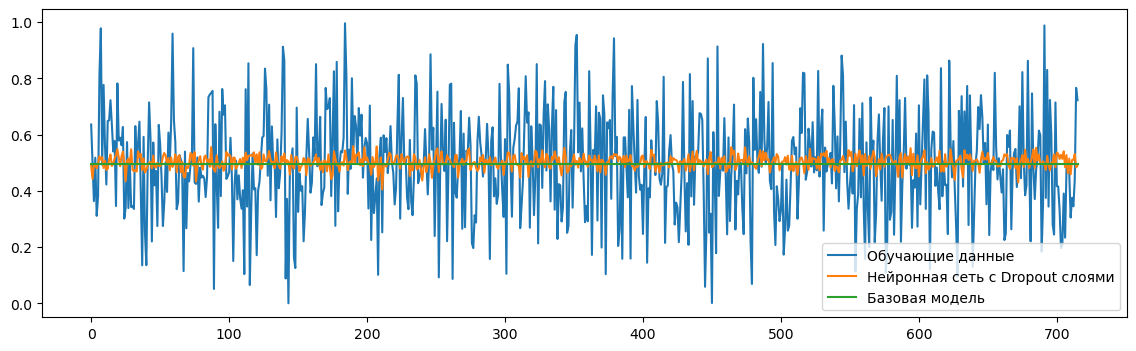

In [54]:
# Визуализация на обучающих данных 
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_train.values, label='Обучающие данные')
ax.plot(preds_matrix_model4_train, label='Нейронная сеть с Dropout слоями')
ax.plot(preds_matrix_dum_train, label='Базовая модель')
ax.legend()
plt.show()

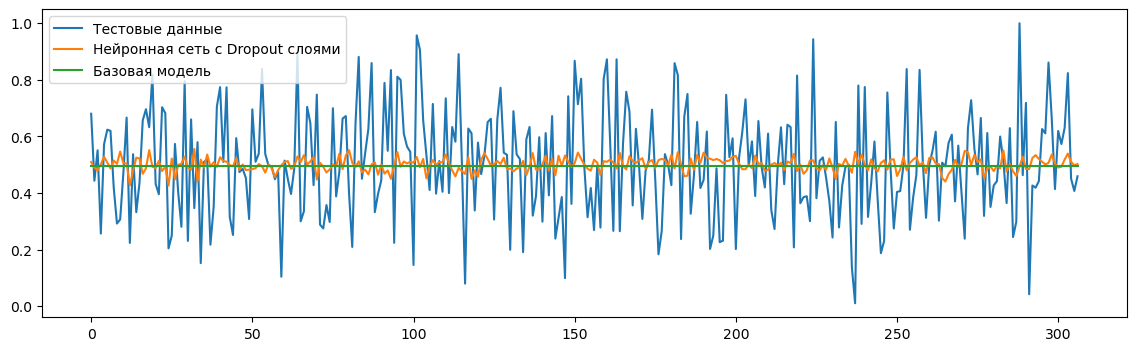

In [55]:
# Визуализация на тестовых данных данных 
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_test.values, label='Тестовые данные')
ax.plot(preds_matrix_model4_test, label='Нейронная сеть с Dropout слоями')
ax.plot(preds_matrix_dum_test, label='Базовая модель')
ax.legend()
plt.show()

Коэффициент детерминации для тестовой выборки положителен, но почти равен нулю

Созданим нейронную сеть со слоем нормализации. Будем использовать исходный датасет, который не масштабировался

In [56]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
matrix_filler,1023.0,2.925149,0.892296,0.547391,2.321061,2.906878,3.548775,5.314144
density,1023.0,1974.780371,70.843060,1784.482245,1924.535020,1977.621657,2020.628746,2161.565216
elastic_modulus,1023.0,737.725703,326.453983,2.436909,500.047452,739.664328,957.386959,1649.415706
hardener,1023.0,110.558141,26.661661,38.668500,92.883002,110.564840,129.233303,181.828448
epoxies,1023.0,22.241659,2.369521,15.695894,20.615227,22.230744,23.961468,28.955094
temp,1023.0,285.949096,39.355511,179.374391,259.372264,285.896812,312.586724,386.067992
surface_density,1023.0,480.887409,278.400280,0.603740,266.816645,451.864365,691.775979,1291.340115
tensile_modulus,1023.0,73.310802,3.042662,65.553336,71.287231,73.268805,75.322176,81.417126
tensile_strength,1023.0,2465.702548,465.480040,1250.392802,2146.295983,2459.524526,2755.823091,3705.672523
resin_consumption,1023.0,218.089920,57.681967,63.685698,179.932410,219.198882,256.760915,359.052220


In [57]:
# Целевая переменная 'Соотношение матрица-наполнитель'
X_matrix_orig = df.copy()
y_matrix_orig = X_matrix_orig.pop('matrix_filler')
X_matrix_orig.shape, y_matrix_orig.shape

((1023, 12), (1023,))

In [58]:
X_matrix_orig.describe().T

,count,mean,std,min,25%,50%,75%,max
density,1023.0,1974.780371,70.843060,1784.482245,1924.535020,1977.621657,2020.628746,2161.565216
elastic_modulus,1023.0,737.725703,326.453983,2.436909,500.047452,739.664328,957.386959,1649.415706
hardener,1023.0,110.558141,26.661661,38.668500,92.883002,110.564840,129.233303,181.828448
epoxies,1023.0,22.241659,2.369521,15.695894,20.615227,22.230744,23.961468,28.955094
temp,1023.0,285.949096,39.355511,179.374391,259.372264,285.896812,312.586724,386.067992
surface_density,1023.0,480.887409,278.400280,0.603740,266.816645,451.864365,691.775979,1291.340115
tensile_modulus,1023.0,73.310802,3.042662,65.553336,71.287231,73.268805,75.322176,81.417126
tensile_strength,1023.0,2465.702548,465.480040,1250.392802,2146.295983,2459.524526,2755.823091,3705.672523
resin_consumption,1023.0,218.089920,57.681967,63.685698,179.932410,219.198882,256.760915,359.052220
patch_angle,1023.0,44.252199,45.015793,0.000000,0.000000,0.000000,90.000000,90.000000


In [59]:
# Разделим на тренировочную и тестовую выборку для задачи с целевой переменной Соотношение матрица-наполнитель
X_matrix_orig_train, X_matrix_orig_test, y_matrix_orig_train, y_matrix_orig_test = train_test_split(X_matrix_orig,
                                                                                                    y_matrix_orig, 
                                                                                                    test_size=0.3,
                                                                                                    random_state=42)
print('X_matrix_orig_train:', X_matrix_orig_train.shape, 'y_matrix_orig_train:', y_matrix_orig_train.shape)
print('X_matrix_orig_test:', X_matrix_orig_test.shape, 'y_matrix_orig_test:', y_matrix_orig_test.shape)

X_matrix_orig_train: (716, 12) y_matrix_orig_train: (716,)
X_matrix_orig_test: (307, 12) y_matrix_orig_test: (307,)


In [60]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [61]:
normalizer.adapt(np.array(X_matrix_orig_train))

In [62]:
print(normalizer.mean.numpy())

[[1972.987     732.41077   110.35613    22.1848    284.48187   478.10107
    73.18202  2462.773     219.16348    45.251396    6.815814   57.3855  ]]


In [63]:
X_matrix_orig_train.describe()

,density,elastic_modulus,hardener,epoxies,temp,surface_density,tensile_modulus,tensile_strength,resin_consumption,patch_angle,patch_step,patch_density
count,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000
mean,1972.987147,732.410807,110.356126,22.184799,284.481882,478.101063,73.182017,2462.773016,219.163489,45.251397,6.815815,57.385503
std,69.336665,317.971188,26.820306,2.391527,39.313917,278.610580,3.024977,467.252400,57.080927,45.030755,2.475882,11.158118
min,1784.482245,2.436909,38.668500,15.695894,179.374391,0.603740,65.553336,1250.392802,75.831812,0.000000,0.000000,27.272928
25%,1923.734314,498.438068,92.902601,20.512606,258.147742,263.746196,71.162269,2135.886086,181.383177,0.000000,5.023830,50.106239
50%,1973.810348,738.736842,110.495498,22.200872,285.287599,449.051543,73.125410,2455.975282,219.285844,90.000000,6.862404,57.341920
75%,2019.154106,941.447504,129.000000,23.890304,309.277439,683.458389,75.222268,2752.338610,257.269283,90.000000,8.492814,64.572130
max,2160.751439,1649.415706,181.828448,28.955094,386.067992,1291.340115,81.203147,3705.672523,359.052220,90.000000,13.484945,86.012427


In [64]:
def baseline_model5(norm):
    model = keras.Sequential()
    model.add(normalizer)
    model.add(Dense(24, input_dim=12 , activation='tanh'))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [65]:
model5 = baseline_model5(normalizer)
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 12)               25        
 n)                                                              
                                                                 
 dense_27 (Dense)            (None, 24)                312       
                                                                 
 dense_28 (Dense)            (None, 24)                600       
                                                                 
 dropout_10 (Dropout)        (None, 24)                0         
                                                                 
 dense_29 (Dense)            (None, 24)                600       
                                                                 
 dropout_11 (Dropout)        (None, 24)                0         
                                                      

In [66]:
%%time
history = model5.fit(
    X_matrix_orig_train,
    y_matrix_orig_train,
    validation_split=0.3,
    verbose=1, epochs=50)

Epoch 1/50
16/16 [==============================] - 4s 55ms/step - loss: 8.5464 - val_loss: 6.9718
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 6.1208 - val_loss: 3.9739
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 2.7439 - val_loss: 1.0777
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 1.0150 - val_loss: 0.9701
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.9925 - val_loss: 0.8366
Epoch 6/50
16/16 [==============================] - 0s 12ms/step - loss: 0.9151 - val_loss: 0.8132
Epoch 7/50
16/16 [==============================] - 0s 14ms/step - loss: 0.9192 - val_loss: 0.7932
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 0.8943 - val_loss: 0.8036
Epoch 9/50
16/16 [==============================] - 0s 29ms/step - loss: 0.8719 - val_loss: 0.7889
Epoch 10/50
16/16 [==============================] - 0s 21ms/step - loss: 0.9189 - val_loss: 0.7924
Epoch 11/

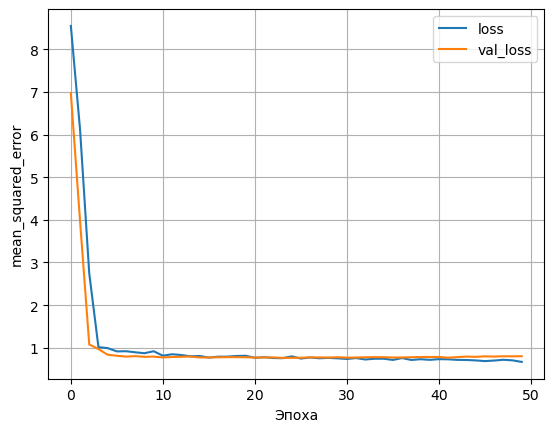

In [67]:
# График ошибки
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid(True)
plt.xlabel('Эпоха')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

Видно, что модель переобучена

In [68]:
# Проверяем точность сети на тренировочных и тестовых данных
train_rezult = model5.evaluate(X_matrix_orig_train, y_matrix_orig_train)
test_rezult = model5.evaluate(X_matrix_orig_test, y_matrix_orig_test)

10/10 [==============================] - 0s 4ms/step - loss: 0.8533


In [69]:
# Предсказание нейросети
preds_matrix_model5_train = model5.predict(X_matrix_orig_train)
preds_matrix_model5_test = model5.predict(X_matrix_orig_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model5_train = mean_absolute_error(y_matrix_orig_train, preds_matrix_model5_train)
MSE_matrix_model5_train = mean_squared_error (y_matrix_orig_train, preds_matrix_model5_train)
r2_matrix_model5_train = r2_score(y_matrix_orig_train, preds_matrix_model5_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_model5_train) 
print('MSE_train:', MSE_matrix_model5_train) 
print('r2_train', r2_matrix_model5_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model5_test = mean_absolute_error(y_matrix_orig_test, preds_matrix_model5_test)
MSE_matrix_model5_test = mean_squared_error (y_matrix_orig_test, preds_matrix_model5_test)
r2_matrix_model5_test = r2_score(y_matrix_orig_test, preds_matrix_model5_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_model5_test) 
print('MSE_train:', MSE_matrix_model5_test) 
print('r2_train', r2_matrix_model5_test)

10/10 [==============================] - 0s 4ms/step
Точность модели на тренировочных данных
MAE_train: 0.6667810432279937
MSE_train: 0.6943806669121828
r2_train 0.10808236984552999

Точность модели на тестовых данных
MAE_train: 0.7641861444255712
MSE_train: 0.8533491020099654
r2_train -0.02275887848328262


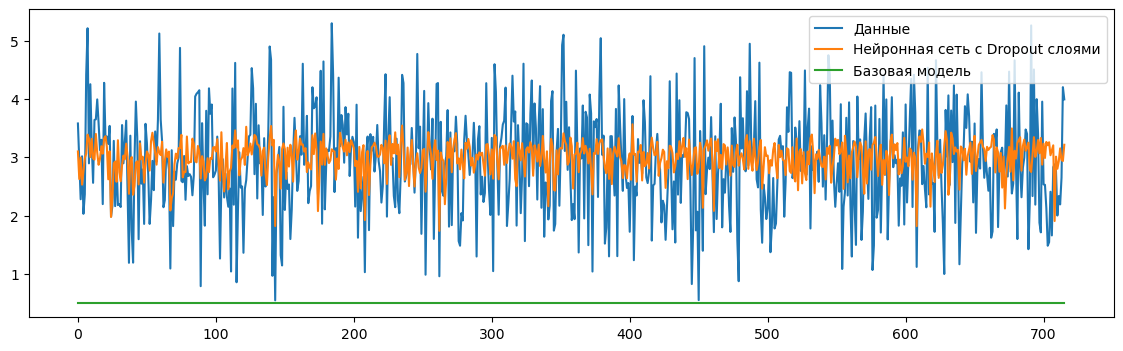

In [70]:
# Визуализация на обучающих данных 
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_orig_train.values, label='Данные')
ax.plot(preds_matrix_model5_train, label='Нейронная сеть с Dropout слоями')
ax.plot(preds_matrix_dum_train, label='Базовая модель')
ax.legend()
plt.show()

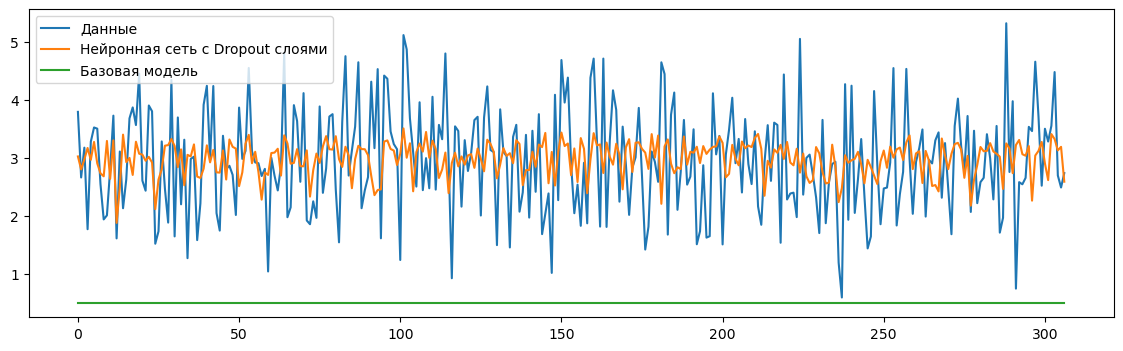

In [71]:
# Визуализация на тестовых данных данных 
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_orig_test.values, label='Данные')
ax.plot(preds_matrix_model5_test, label='Нейронная сеть с Dropout слоями')
ax.plot(preds_matrix_dum_test, label='Базовая модель')
ax.legend()
plt.show()

Точность на тестовой выборке значительно лучше, чем в других нейросетях, но на тестовой выборке результат немного худе, чем у модели 4

Сравнение нейросетей по метрикам

In [72]:
# Сравниваем наши модели по метрикам для тренировочной и тестовой выборки
metrics_df = {'Регрессор': ['DummerRegressor', 'NS 2 слоя по 8 нейронов', 'NS 2 слоя по 8 нейронов, adam', 'NS 6 слоев по 8 нейронов',
                            'NS 6 слоев по 8 нейронов + Dropout', 'NS 6 слоев по 24 нейронa + Dropout',
                            'NS 6 слоев по 24 нейронa + Dropout + norm'], 
         'r2_train': [r2_matrix_dum_train, r2_matrix_model1_train, r2_matrix_model1_1_train, r2_matrix_model2_train,
                     r2_matrix_model3_train, r2_matrix_model4_train, r2_matrix_model5_train],
         'MAE_train': [MAE_matrix_dum_train, MAE_matrix_model1_train, MAE_matrix_model1_1_train, MAE_matrix_model2_train,
                      MAE_matrix_model3_train, MAE_matrix_model4_train, MAE_matrix_model5_train],
         'MSE_train': [MSE_matrix_dum_train, MSE_matrix_model1_train, MSE_matrix_model1_1_train, MSE_matrix_model2_train,
                      MSE_matrix_model3_train, MSE_matrix_model4_train, MSE_matrix_model5_train],
        'r2_test': [r2_matrix_dum_test, r2_matrix_model1_test, r2_matrix_model1_1_test,  r2_matrix_model2_test,
                    r2_matrix_model3_test,  r2_matrix_model4_test,  r2_matrix_model5_test],
         'MAE_test': [MAE_matrix_dum_test, MAE_matrix_model1_test, MAE_matrix_model1_1_test, MAE_matrix_model2_test,
                     MAE_matrix_model3_test, MAE_matrix_model4_test, MAE_matrix_model5_test],
         'MSE_test': [MSE_matrix_dum_test, MSE_matrix_model1_test, MSE_matrix_model1_1_test, MSE_matrix_model2_test,
                     MSE_matrix_model3_test, MSE_matrix_model4_test, MSE_matrix_model5_test]
         } 

metrics_df = pd.DataFrame(metrics_df)
metrics_df

,Регрессор,r2_train,MAE_train,MSE_train,r2_test,MAE_test,MSE_test
0,DummerRegressor,0.000000,0.147047,0.034263,-0.000755,0.155986,0.036748
1,NS 2 слоя по 8 нейронов,0.001675,0.147687,0.034206,-0.058062,0.160638,0.038853
2,"NS 2 слоя по 8 нейронов, adam",0.002946,0.148144,0.034162,0.013993,0.155486,0.036207
3,NS 6 слоев по 8 нейронов,0.016822,0.146083,0.033687,-0.015827,0.157698,0.037302
4,NS 6 слоев по 8 нейронов + Dropout,0.012985,0.146887,0.033818,-0.021496,0.158960,0.037510
5,NS 6 слоев по 24 нейронa + Dropout,0.016646,0.146255,0.033693,-0.019507,0.157996,0.037437
6,NS 6 слоев по 24 нейронa + Dropout + norm,0.108082,0.666781,0.694381,-0.022759,0.764186,0.853349


Нейросети из библиотеки Tensorflow старались подстроитьс под данные, но метрики разочаровывают. Лучшая обобщающая способность на тестовой выборке оказаласть у нейросети с 2 слоями по 8 нейронов с оптимизатером adam. Она хоть и немного, но предсказывает лучше базовой модели. Коэффициент детерминации положительный, но очень близкий к нулю - 0.013

In [74]:
# Перевод предсказанных данных из нормализованных в исходные

result_reverse = minmax_scaler.inverse_transform(preds_matrix_model1_1_test)
initial_data = pd.DataFrame(result_reverse)
initial_data

,0
0,2.781408
1,2.914689
2,2.800977
3,2.841572
4,2.910683
...,...
302,3.147600
303,3.061397
304,2.905164
305,2.936924
